In [13]:
import tensorflow as tf
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import scipy
import os
from glob import glob
from tqdm import tqdm
import tensorflow_datasets as tfds
from IPython import display

Note: current env is called micro_speech_model_maker in conda

In [14]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Importing Data

[Dataset Paper](https://arxiv.org/pdf/1804.03209)

[Dataset importer github](https://github.com/tensorflow/datasets/tree/master/tensorflow_datasets/datasets/speech_commands)

[TF example for data subset](https://www.tensorflow.org/tutorials/audio/simple_audio)

Right now we will only be using a mini dataset to explore data and test data augmentations plus do some preliminary model training and quantization

In [15]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [16]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [17]:
ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=None, #Unbatched dataset
    validation_split=0, #We will do split manually
    seed=seed,
    output_sequence_length=16000
    )

label_names = np.array(ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [18]:
# Define target and unknown keywords
target_keywords = ['up', 'down', 'left', 'right']
unknown_keywords = [label for label in label_names if label not in target_keywords]

print("Target Keywords:", target_keywords)
print("Unknown Keywords:", unknown_keywords)

Target Keywords: ['up', 'down', 'left', 'right']
Unknown Keywords: ['go', 'no', 'stop', 'yes']


In [21]:
# New label names including 'unknown' and 'silence'
new_label_names = ['up', 'down', 'left', 'right', 'unknown', 'silence']
new_class_to_index = {name: index for index, name in enumerate(new_label_names)}
print("New Class to Index Mapping:", new_class_to_index)

# Map old label indices to new label indices
old_label_to_new_label_index = {}
for idx, label_name in enumerate(label_names):
    if label_name in target_keywords:
        new_label = label_name
    else:
        new_label = 'unknown'
    new_label_index = new_class_to_index[new_label]
    old_label_to_new_label_index[idx] = new_label_index

# Create a mapping array for efficient lookup
mapping_array = tf.constant([old_label_to_new_label_index[idx] for idx in range(len(label_names))], dtype=tf.int32)


New Class to Index Mapping: {'up': 0, 'down': 1, 'left': 2, 'right': 3, 'unknown': 4, 'silence': 5}


In [22]:
def map_labels(sample, label):
    # Map the old label index to the new label index
    new_label = tf.gather(mapping_array, label)
    return sample, new_label

# Map labels in the dataset
ds = ds.map(map_labels)

In [23]:
# Number of silence samples to add
num_silence_samples = 2000  # Adjust as needed

def generate_silence_sample():
    # Create a 1-second silent audio sample at 16kHz
    sample = tf.zeros([16000], dtype=tf.float32)
    # Assign the label index for 'silence'
    label = new_class_to_index['silence']
    return sample, label

# Create a dataset of silence samples
silence_ds = tf.data.Dataset.from_tensor_slices([0]*num_silence_samples)
silence_ds = silence_ds.map(lambda x: generate_silence_sample())

In [24]:
#Squeeze the audio tensor to remove the channel dimension
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

ds = ds.map(squeeze)

In [25]:
# Combine the original dataset with the silence dataset
ds = ds.concatenate(silence_ds)

In [26]:
# Shuffle and batch the dataset
ds = ds.shuffle(10000).batch(64)

In [27]:
# Verify the dataset
for samples, labels in ds.take(1):
    print("\nSamples shape:", samples.shape)
    print("Labels shape:", labels.shape)
    print("Unique labels in batch:", np.unique(labels.numpy()))


Samples shape: (64, 16000)
Labels shape: (64,)
Unique labels in batch: [0 1 2 3 4 5]


In [29]:
# Reverse mapping from indices to class names
index_to_class = {index: name for name, index in new_class_to_index.items()}

In [30]:
ds_unbatched = ds.unbatch()

# Initialize a dictionary to store one sample per class
samples_per_class = {}

# Iterate through the unbatched dataset
for sample, label in ds_unbatched:
    label_int = label.numpy()
    label_name = index_to_class[label_int]
    # If we haven't collected a sample for this class yet, store it
    if label_name not in samples_per_class:
        samples_per_class[label_name] = sample.numpy()
    # Break the loop if we've collected samples for all classes
    if len(samples_per_class) == len(new_label_names):
        break

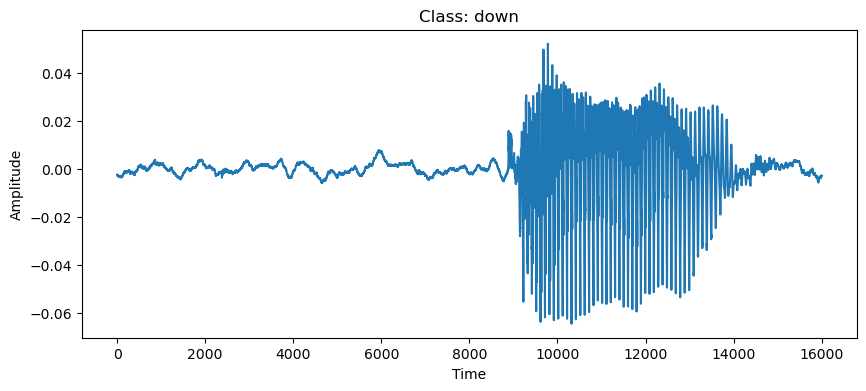

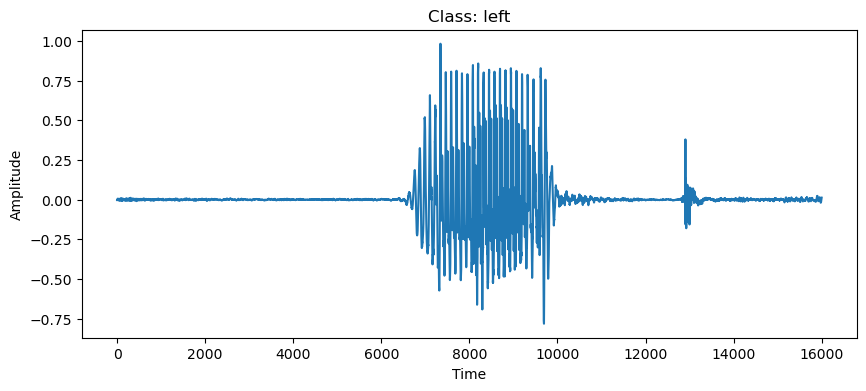

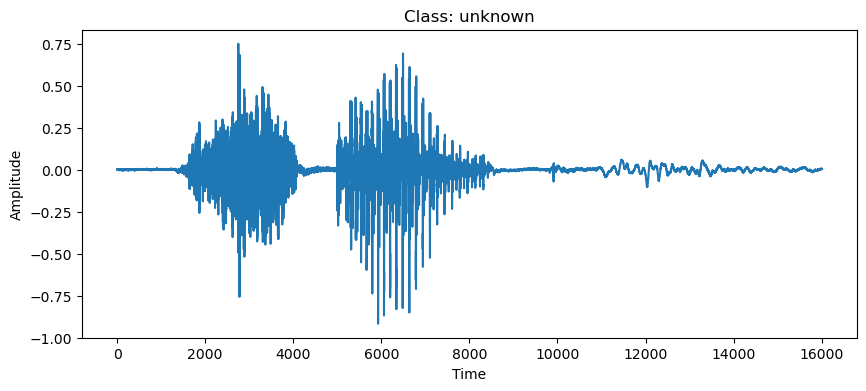

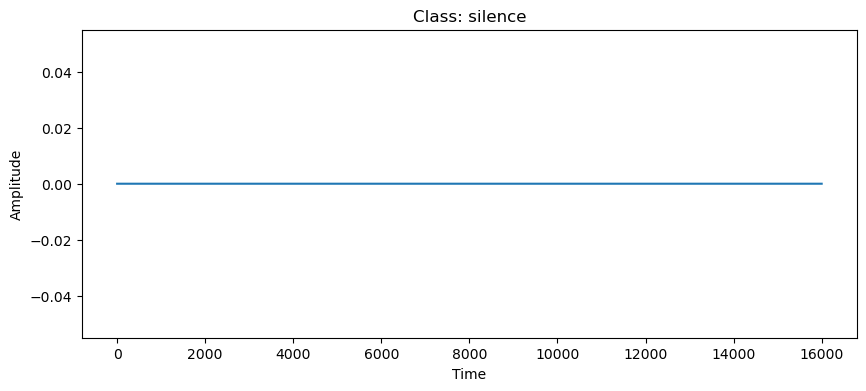

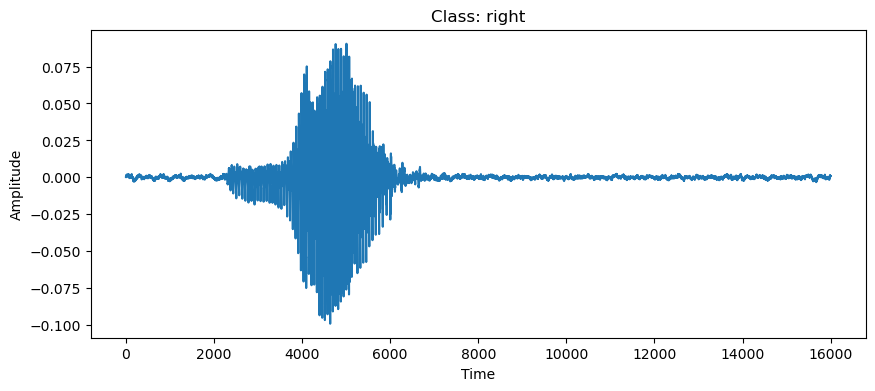

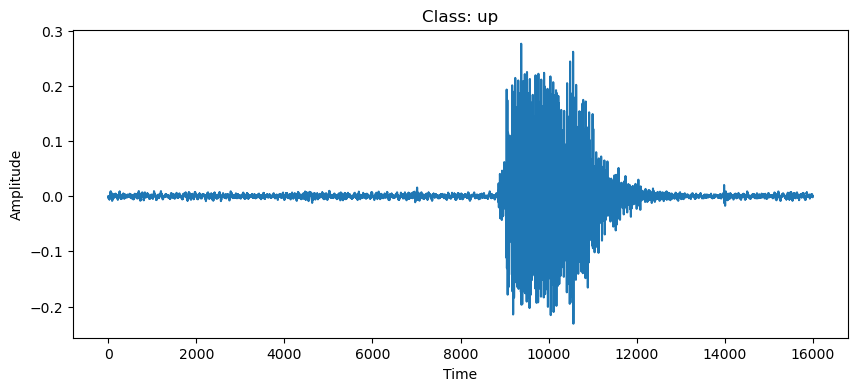

In [31]:
# Plotting the waveforms
for label_name, sample in samples_per_class.items():
    # Reshape the sample to [16000] from [16000, 1] for plotting
    sample = sample.reshape(-1)
    plt.figure(figsize=(10, 4))
    plt.plot(sample)
    plt.title(f"Class: {label_name}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

In [32]:
# Reset the unbatched dataset and cache it
ds_unbatched = ds.unbatch().cache()

# Count the total number of samples in dataset
total_samples = ds_unbatched.reduce(np.int64(0), lambda x, _: x + 1).numpy()
print(f"Total number of samples: {total_samples}")

Total number of samples: 10000


## Data Split

In [33]:
# Shuffle the dataset with a buffer size equal to the total number of samples
ds_unbatched = ds_unbatched.shuffle(total_samples, reshuffle_each_iteration=False)

In [34]:
# Calculate sizes for each split
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size  # Ensure all samples are included


In [35]:
# Create the training dataset
train_ds = ds_unbatched.take(train_size)

# Create the validation dataset
val_ds = ds_unbatched.skip(train_size).take(val_size)

# Create the test dataset
test_ds = ds_unbatched.skip(train_size + val_size)


In [36]:
# Define the batch size
batch_size = 64

# Batch the datasets
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [38]:
# Function to count batches in a dataset
def count_batches(dataset):
    return sum(1 for _ in dataset)

# Count batches in each dataset
num_train_batches = count_batches(train_ds)
num_val_batches = count_batches(val_ds)
num_test_batches = count_batches(test_ds)

print(f"Number of training batches: {num_train_batches}")
print(f"Number of validation batches: {num_val_batches}")
print(f"Number of test batches: {num_test_batches}")

# Function to count samples in a dataset
def count_samples(dataset):
    return dataset.reduce(np.int32(0), lambda x, batch: x + tf.shape(batch[0])[0]).numpy()

# Count samples in each dataset
num_train_samples = count_samples(train_ds)
num_val_samples = count_samples(val_ds)
num_test_samples = count_samples(test_ds)

print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")
print(f"Number of test samples: {num_test_samples}")

Number of training batches: 125
Number of validation batches: 16
Number of test batches: 16
Number of training samples: 8000
Number of validation samples: 1000
Number of test samples: 1000


## Convert to Spectogram

In [39]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [45]:
# Get one batch from the training dataset
for waveform_batch, label_batch in train_ds.take(1):
    example_waveforms = waveform_batch
    example_labels = label_batch

In [47]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


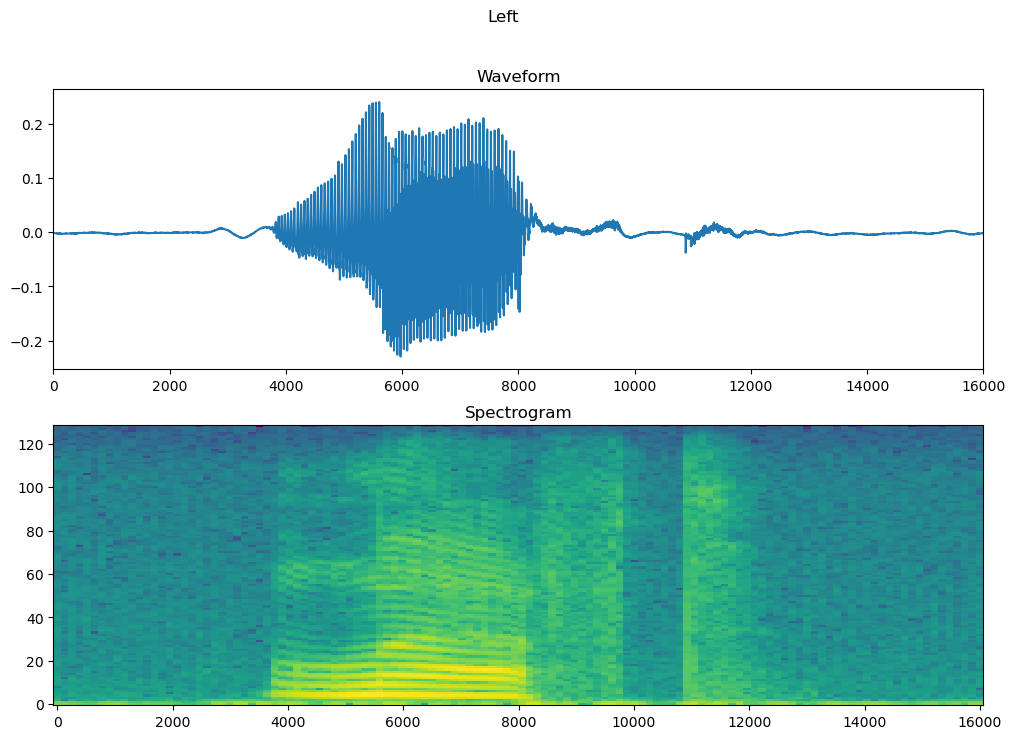

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


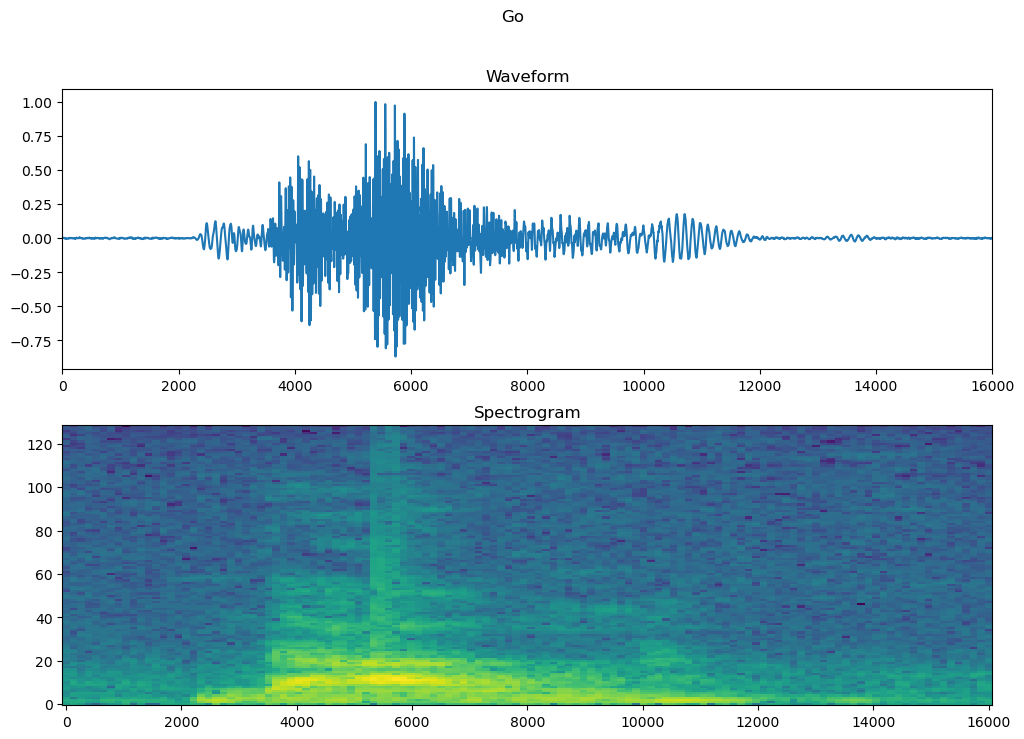

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


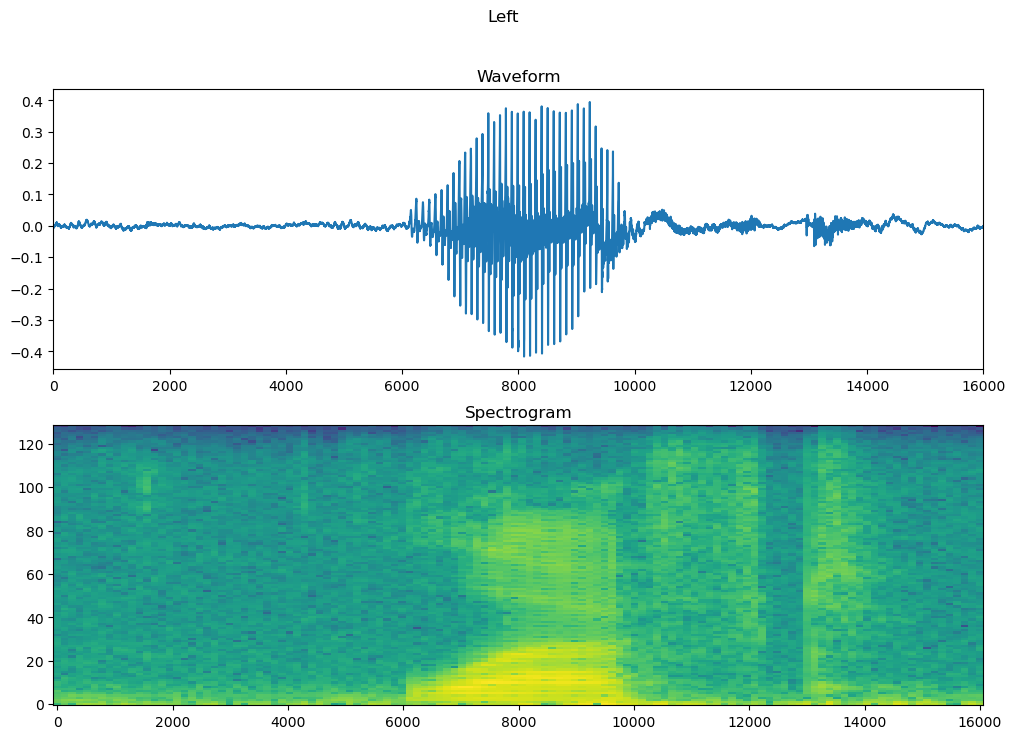

In [53]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_waveforms[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

  fig, axes = plt.subplots(2, figsize=(12, 8))
  timescale = np.arange(waveform.shape[0])
  axes[0].plot(timescale, waveform.numpy())
  axes[0].set_title('Waveform')
  axes[0].set_xlim([0, 16000])

  plot_spectrogram(spectrogram.numpy(), axes[1])
  axes[1].set_title('Spectrogram')
  plt.suptitle(label.title())
  plt.show()

In [55]:
# Function to convert dataset waveforms to spectrograms
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio, label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [56]:
# Apply the spectrogram conversion to the datasets
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

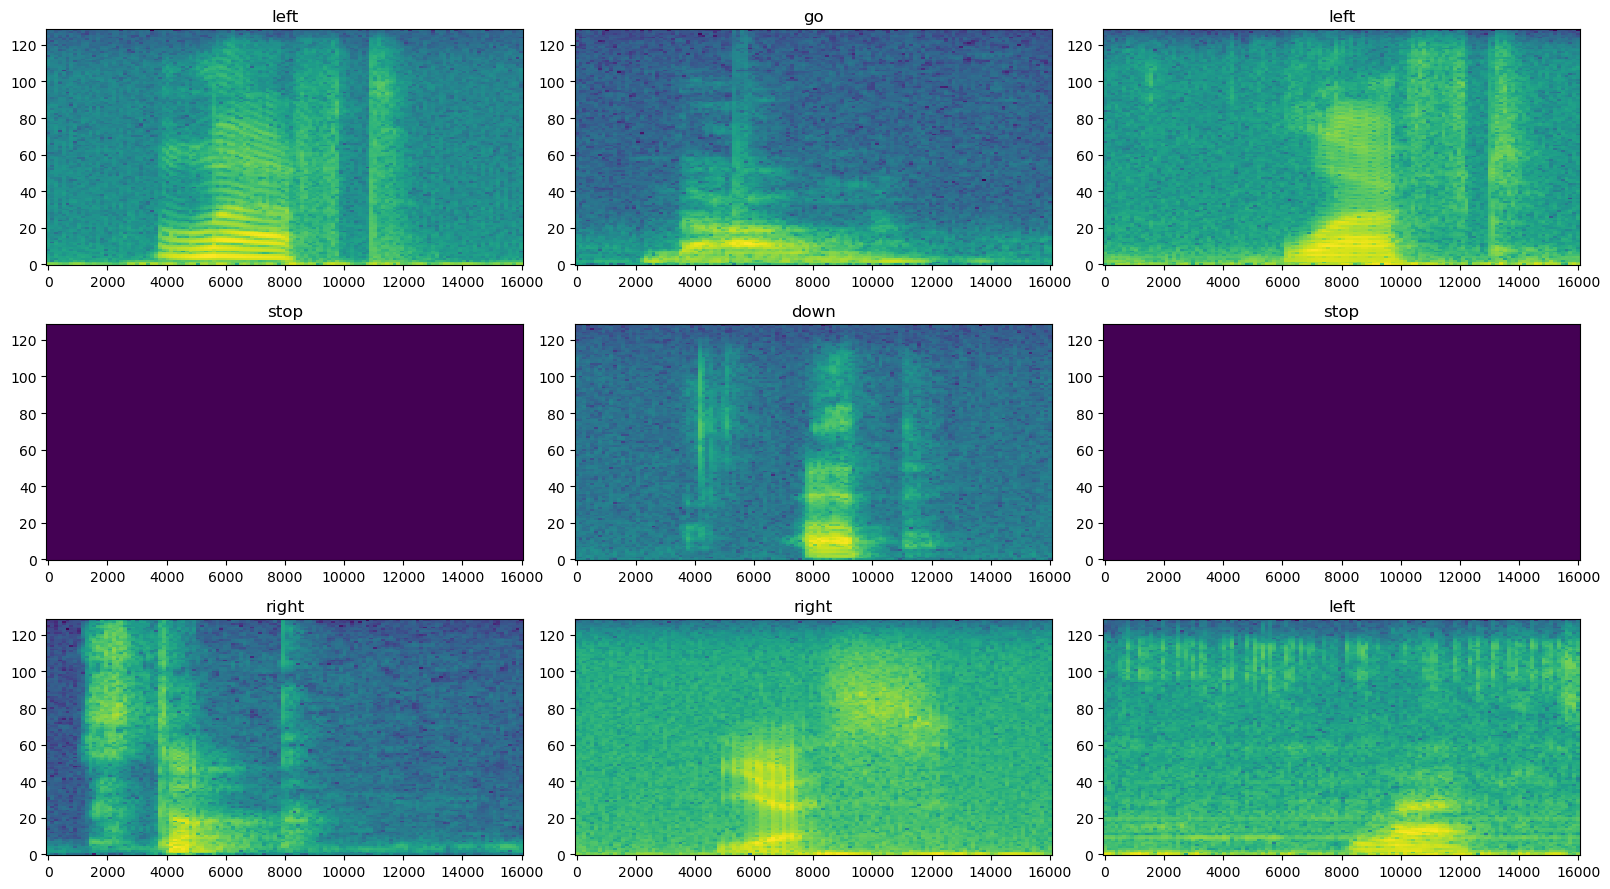

In [57]:
# Get one batch from the spectrogram dataset for visualization
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])
    
plt.tight_layout()
plt.show()
